### This script does basic bhv quantifications
#### this script runs DLC and quantifies the gazes
#### this script focuses on the summarizing results pooling all four animals (two dyads); it can only be run after the "BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [11]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)
### separate each session based on trial types (different force levels)

In [12]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 1*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = '_allsessions'
    

# force manipulation type
# SR_bothchange: self reward, both forces changed
# CO_bothchange: 1s cooperation, both forces changed
# CO_A1change: 1s cooperation, animal 1 forces changed
# CO_A2change: 1s cooperation, animal 2 forces changed
forceManiTypes = ['SR_bothchange','CO_A1change','CO_A2change']
nforceManiTypes = np.shape(forceManiTypes)[0]

#  
animal1_fixedorders = ['koala','dannon']
animal2_fixedorders = ['vermelho','kanga']

animal1_filenames = ["Koala","Dannon"]
animal2_filenames = ["Vermelho","Kanga"]

nanimalpairs = np.shape(animal1_fixedorders)[0]


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/'


    

In [13]:
# load data for all animals
summary_all_results = pd.DataFrame(columns=['date','forceContType','self_animal','partner_animal','subblockID',
                                            'self_force','partner_force','trialnum','blocktime',
                                            'succ_rate','interpullintv','pull_IPI','pull_IPI_std',
                                            'gaze_number','pull_number','lever_holdtime',
                                            'lever_holdtime_std','lever_gauge','lever_gauge_std',
                                            'ccf_acrossAnimalsPulls','ccf_withinAnimalpullgaze','ccf_acrossAnimalspullgaze'])


for ianimalpair in np.arange(0,nanimalpairs,1):
    
    animal1_fixedorder = [animal1_fixedorders[ianimalpair]]
    animal2_fixedorder = [animal2_fixedorders[ianimalpair]]
    
    animal1_filename = animal1_filenames[ianimalpair]
    animal2_filename = animal2_filenames[ianimalpair]
    
    # load data for all manipulation types
    for iforceManiType in np.arange(0,nforceManiTypes,1):
        
        forceManiType = forceManiTypes[iforceManiType]
        
    
        # load saved data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

        with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            animal1_name_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            animal2_name_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            trialdates_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            force1_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            force2_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            subblockID_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            succ_rate1_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            succ_rate2_all_dates = pickle.load(f)
            
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            blocktime_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            interpullintv_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull1_IPI_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull1_IPI_std_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull2_IPI_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull2_IPI_std_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)     
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/lever1_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever1_holdtime_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever1_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever1_holdtime_std_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever2_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever2_holdtime_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever2_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever2_holdtime_std_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/lever1_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever1_gauge_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever1_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever1_gauge_std_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever2_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever2_gauge_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/lever2_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            lever2_gauge_std_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            bhv_intv_all_dates = pickle.load(f)
        
        with open(data_saved_subfolder+'/cross_corr_bhv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            cross_corr_bhv_all_dates = pickle.load(f)

        print('all data are loaded:'+animal1_fixedorder[0]+' '+animal2_fixedorder[0]+' '+forceManiType)

        # 
        ndates = np.shape(trialdates_all_dates)[0]
        
        for idate in np.arange(0,ndates,1):
            
            if forceManiType == 'SR_bothchange':
                animal1_forceContType = 'self_change_SR'
                animal2_forceContType = 'self_change_SR'
            elif forceManiType == 'CO_A1change':
                animal1_forceContType = 'self_change_MC'
                animal2_forceContType = 'partner_change_MC'
            elif forceManiType == 'CO_A2change':
                animal1_forceContType = 'partner_change_MC'
                animal2_forceContType = 'self_change_MC'
            else:
                animal1_forceContType = None
                animal2_forceContType = None
            
            cross_corr_allbhv_tgt = cross_corr_bhv_all_dates[trialdates_all_dates[idate]][str(int(force1_all_dates[idate]))+'&'+str(int(force2_all_dates[idate]))]
            
            # center at pull1, xcorr of pull2
            cross_corr_allbhv_pull1pull2 = cross_corr_allbhv_tgt['pull1']['pull2']
            # center at pull1, xcorr of gaze1
            cross_corr_allbhv_pull1gaze1 = cross_corr_allbhv_tgt['pull1']['gaze1']
            # center at pull1, xcorr of gaze2
            cross_corr_allbhv_pull1gaze2 = cross_corr_allbhv_tgt['pull1']['gaze2']
            
            # center at pull2, xcorr of pull1
            cross_corr_allbhv_pull2pull1 = cross_corr_allbhv_tgt['pull2']['pull1']
            # center at pull2, xcorr of gaze2
            cross_corr_allbhv_pull2gaze2 = cross_corr_allbhv_tgt['pull2']['gaze2']
            # center at pull2, xcorr of gaze1
            cross_corr_allbhv_pull2gaze1 = cross_corr_allbhv_tgt['pull2']['gaze1']
            
            # for animal1
            summary_all_results = summary_all_results.append({
                                                        'date': trialdates_all_dates[idate],
                                                        'forceContType':animal1_forceContType,
                                                        'self_animal': animal1_fixedorder[0],
                                                        'partner_animal': animal2_fixedorder[0],
                                                        'subblockID': subblockID_all_dates[idate],
                                                        'self_force': force1_all_dates[idate],
                                                        'partner_force': force2_all_dates[idate],
                                                        'trialnum': trialnum_all_dates[idate],
                                                        'blocktime': blocktime_all_dates[idate],
                                                        # 'succ_rate': succ_rate_all_dates[idate],
                                                        'succ_rate': succ_rate1_all_dates[idate],
                                                        'interpullintv': interpullintv_all_dates[idate],
                                                        'pull_IPI': pull1_IPI_all_dates[idate],
                                                        'pull_IPI_std': pull1_IPI_std_all_dates[idate],
                                                        'gaze_number': owgaze1_num_all_dates[idate]+mtgaze1_num_all_dates[idate],
                                                        'pull_number': pull1_num_all_dates[idate],
                                                        'lever_holdtime': lever1_holdtime_all_dates[idate],
                                                        'lever_holdtime_std': lever1_holdtime_std_all_dates[idate],
                                                        'lever_gauge': lever1_gauge_all_dates[idate],
                                                        'lever_gauge_std': lever1_gauge_std_all_dates[idate],
                                                        'ccf_acrossAnimalsPulls':cross_corr_allbhv_pull1pull2,
                                                        'ccf_withinAnimalpullgaze':cross_corr_allbhv_pull1gaze1,
                                                        'ccf_acrossAnimalspullgaze':cross_corr_allbhv_pull1gaze2,
                                                    }, ignore_index=True)
            
            # for animal2
            summary_all_results = summary_all_results.append({
                                                        'date': trialdates_all_dates[idate],
                                                        'forceContType':animal2_forceContType,
                                                        'self_animal': animal2_fixedorder[0],
                                                        'partner_animal': animal1_fixedorder[0],
                                                        'subblockID': subblockID_all_dates[idate],
                                                        'self_force': force2_all_dates[idate],
                                                        'partner_force': force1_all_dates[idate],
                                                        'trialnum': trialnum_all_dates[idate],
                                                        'blocktime': blocktime_all_dates[idate],
                                                        # 'succ_rate': succ_rate_all_dates[idate],
                                                        'succ_rate': succ_rate2_all_dates[idate],
                                                        'interpullintv': interpullintv_all_dates[idate],
                                                        'pull_IPI': pull2_IPI_all_dates[idate],
                                                        'pull_IPI_std': pull2_IPI_std_all_dates[idate],
                                                        'gaze_number': owgaze2_num_all_dates[idate]+mtgaze2_num_all_dates[idate],
                                                        'pull_number': pull2_num_all_dates[idate],
                                                        'lever_holdtime': lever2_holdtime_all_dates[idate],
                                                        'lever_holdtime_std': lever2_holdtime_std_all_dates[idate],
                                                        'lever_gauge': lever2_gauge_all_dates[idate],
                                                        'lever_gauge_std': lever2_gauge_std_all_dates[idate],
                                                        'ccf_acrossAnimalsPulls':cross_corr_allbhv_pull2pull1,
                                                        'ccf_withinAnimalpullgaze':cross_corr_allbhv_pull2gaze2,
                                                        'ccf_acrossAnimalspullgaze':cross_corr_allbhv_pull2gaze1,
                                                    }, ignore_index=True)
            
# calculating gaze and pull number per second
summary_all_results['gazenum_pers'] = summary_all_results['gaze_number']/summary_all_results['blocktime']
summary_all_results['pullnum_pers'] = summary_all_results['pull_number']/summary_all_results['blocktime']

# calculating successful pull number per second
summary_all_results['succpullnum_pers'] = summary_all_results['pullnum_pers']*summary_all_results['succ_rate']


# remove entries that has too few trial number
trialnum_threshold = 4

ind_bad = summary_all_results['trialnum']<trialnum_threshold

summary_all_results = summary_all_results[~ind_bad].reset_index(drop=True)

all data are loaded:koala vermelho SR_bothchange
all data are loaded:koala vermelho CO_A1change
all data are loaded:koala vermelho CO_A2change
all data are loaded:dannon kanga SR_bothchange
all data are loaded:dannon kanga CO_A1change
all data are loaded:dannon kanga CO_A2change


In [14]:
# create dataframe for the blockID regressed for each day versions
summary_all_results_blockIDregressed = summary_all_results.copy()

unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
ncombines = np.shape(unique_combinations)[0]

columns_todo = ['trialnum','blocktime','succ_rate','interpullintv',
                'pull_IPI','pull_IPI_std','gaze_number','pull_number',
                'lever_holdtime','lever_holdtime_std','lever_gauge','lever_gauge_std',
                'gazenum_pers','pullnum_pers','succpullnum_pers']
ntodos = np.shape(columns_todo)[0]

for icombine in np.arange(0,ncombines,1):
    
    date_tgt = list(unique_combinations['date'])[icombine]
    selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]
    
    # ind_tgt = (summary_all_results_blockIDregressed['date']==date_tgt)&\
    # (summary_all_results_blockIDregressed['self_animal']==selfanimal_tgt)
    ind_tgt = (summary_all_results_blockIDregressed['self_animal']==selfanimal_tgt)

    xxx = np.array(summary_all_results_blockIDregressed['subblockID'][ind_tgt])
    # in case some subblock is removed due to low trial number
    # xxx = np.arange(0,np.shape(xxx)[0],1)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_blockIDregressed[column_todo][ind_tgt])
        
        # regress again subblock ID first
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
        # 
        yyy_res = yyy - (xxx*slope+intercept)

        # Update the DataFrame with residuals for the current column
        summary_all_results_blockIDregressed.loc[ind_tgt, column_todo] = yyy_res

print('create dataframe for the blockID regressed for each day versions')

create dataframe for the blockID regressed for each day versions


In [15]:
# create dataframe for the delta force versions - first force
summary_all_results_deltafirstforce = summary_all_results.copy()
summary_all_results_blockIDregressed_deltafirstforce = summary_all_results_blockIDregressed.copy()


unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
ncombines = np.shape(unique_combinations)[0]

columns_todo = ['self_force','partner_force']
ntodos = np.shape(columns_todo)[0]

for icombine in np.arange(0,ncombines,1):
    
    date_tgt = list(unique_combinations['date'])[icombine]
    selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]
    
    # for normal dataset
    ind_tgt = (summary_all_results_deltafirstforce['date']==date_tgt)&\
    (summary_all_results_deltafirstforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_deltafirstforce[column_todo][ind_tgt])
       
        yyy_new = yyy - yyy[0]
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_deltafirstforce.loc[ind_tgt, column_todo] = yyy_new
    
    # for dataset with subblockID regressed residual
    ind_tgt = (summary_all_results_blockIDregressed_deltafirstforce['date']==date_tgt)&\
    (summary_all_results_blockIDregressed_deltafirstforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_blockIDregressed_deltafirstforce[column_todo][ind_tgt])
       
        yyy_new = yyy - yyy[0]
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_blockIDregressed_deltafirstforce.loc[ind_tgt, column_todo] = yyy_new
    
    
       
print('create dataframe for the delta force versions - first force')

# summary_all_results_blockIDregressed_deltafirstforce

create dataframe for the delta force versions - first force


In [16]:
# create dataframe for the delta force versions - previous force
summary_all_results_deltapreforce = summary_all_results.copy()
summary_all_results_blockIDregressed_deltapreforce = summary_all_results_blockIDregressed.copy()


unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
ncombines = np.shape(unique_combinations)[0]

columns_todo = ['partner_force','self_force',]
ntodos = np.shape(columns_todo)[0]

for icombine in np.arange(0,ncombines,1):
    
    date_tgt = list(unique_combinations['date'])[icombine]
    selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]
    
    # for normal dataset
    ind_tgt = (summary_all_results_deltapreforce['date']==date_tgt)&\
    (summary_all_results_deltapreforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_deltapreforce[column_todo][ind_tgt])
       
        yyy_new = yyy - np.hstack([yyy[0],yyy[0:-1]])
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_deltapreforce.loc[ind_tgt, column_todo] = yyy_new
    
    # for dataset with subblockID regressed residual
    ind_tgt = (summary_all_results_blockIDregressed_deltapreforce['date']==date_tgt)&\
    (summary_all_results_blockIDregressed_deltapreforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_blockIDregressed_deltapreforce[column_todo][ind_tgt])
       
        yyy_new = yyy - np.hstack([yyy[0],yyy[0:-1]])
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_blockIDregressed_deltapreforce.loc[ind_tgt, column_todo] = yyy_new
    
    
       
print('create dataframe for the delta force versions - previous force')

# summary_all_results_blockIDregressed_deltafirstforce

create dataframe for the delta force versions - previous force


In [17]:
# create dataframe for the normalized force each day versions
summary_all_results_normforce = summary_all_results.copy()
summary_all_results_blockIDregressed_normforce = summary_all_results_blockIDregressed.copy()


unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
ncombines = np.shape(unique_combinations)[0]

columns_todo = ['self_force','partner_force']
ntodos = np.shape(columns_todo)[0]

for icombine in np.arange(0,ncombines,1):
    
    date_tgt = list(unique_combinations['date'])[icombine]
    selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]
    
    # for normal dataset
    ind_tgt = (summary_all_results_normforce['date']==date_tgt)&\
    (summary_all_results_normforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_normforce[column_todo][ind_tgt])
       
        yyy_new = st.zscore(yyy)
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_normforce.loc[ind_tgt, column_todo] = yyy_new
    
    # for dataset with subblockID regressed residual
    ind_tgt = (summary_all_results_blockIDregressed_normforce['date']==date_tgt)&\
    (summary_all_results_blockIDregressed_normforce['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_blockIDregressed_normforce[column_todo][ind_tgt])
       
        yyy_new = st.zscore(yyy)
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_blockIDregressed_normforce.loc[ind_tgt, column_todo] = yyy_new
    
    
       
print('create dataframe for the normalized force each day versions')

# summary_all_results_blockIDregressed_deltafirstforce

create dataframe for the normalized force each day versions


### plot the summarizing figures with all animals
#### different variables plot against self force level or other force level
#### separating condition (self sr, other sr, self mc, other mc etc)
#### choose the version of the variables - raw, normalized force, or delta force; raw or blockiD regressed residuals

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

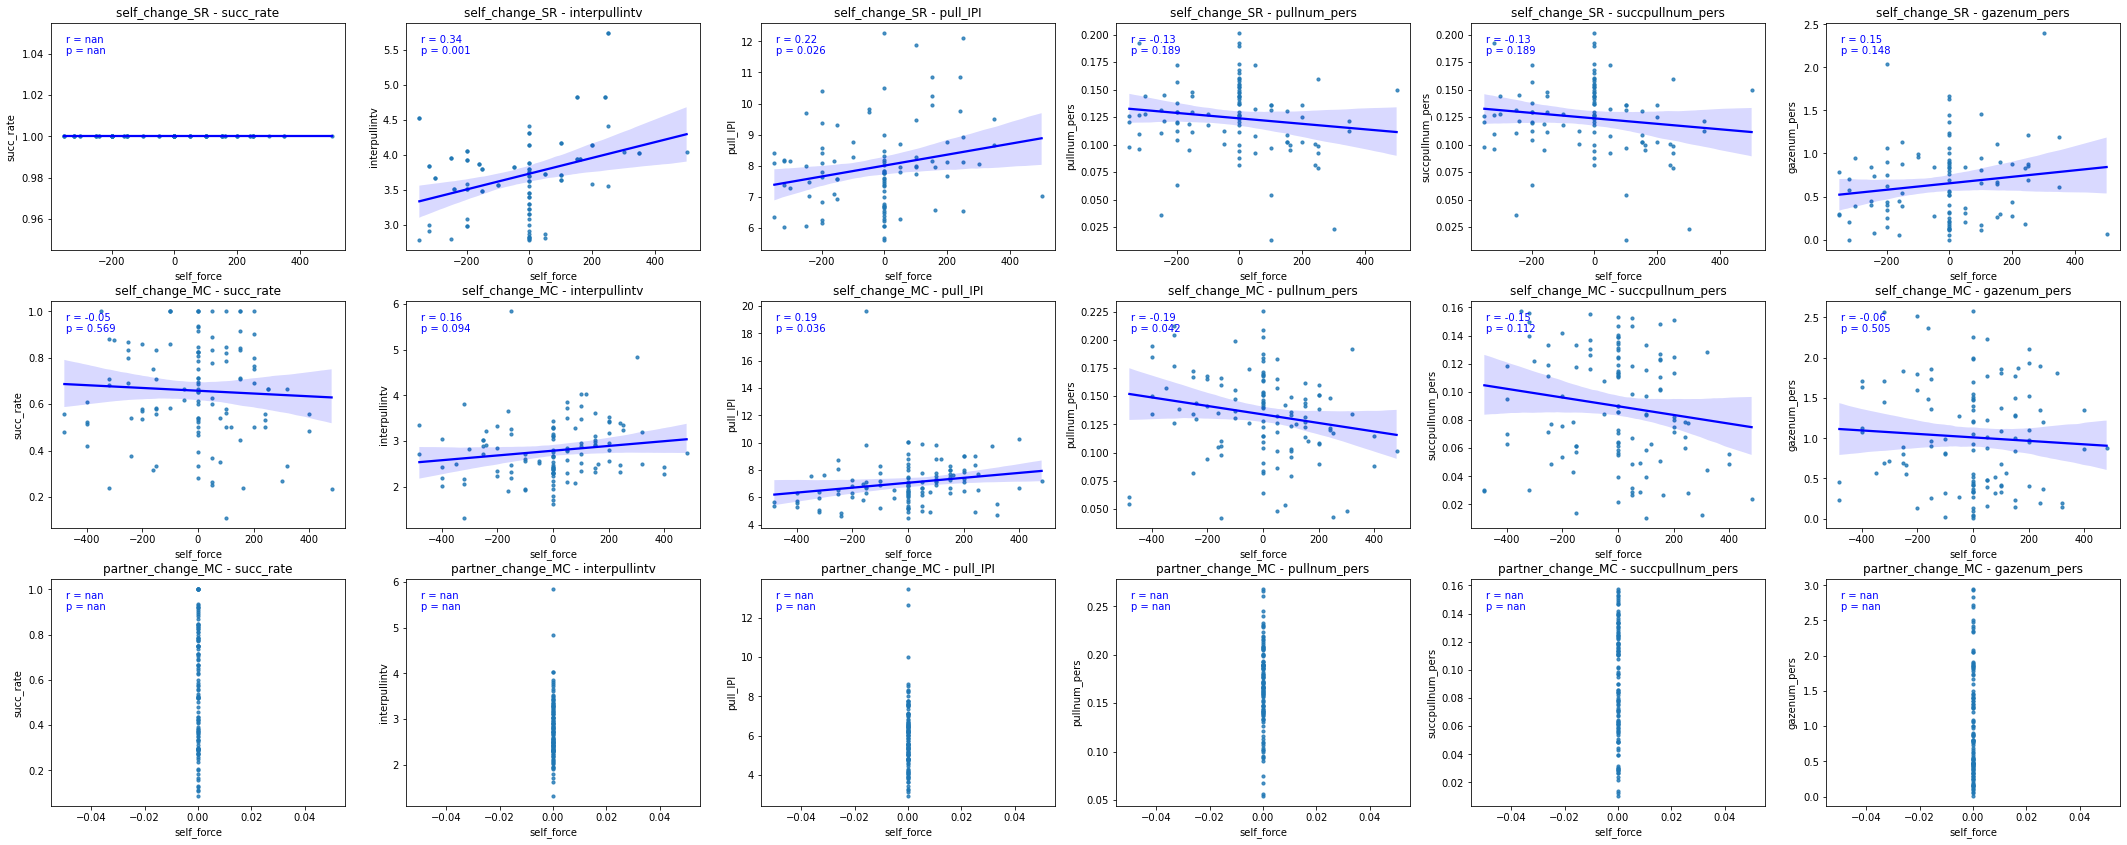

In [19]:
# datatypename = '' # 'blockIDregressed_normforce','blockIDregressed_deltafirstforce','blockIDregressed_deltapreforce'
# summary_all_tgt = summary_all_results
datatypename = 'deltapreforce'
summary_all_tgt = summary_all_results_deltapreforce

nTrialConds = np.shape(np.unique(summary_all_tgt['forceContType']))[0]

xplottype = 'self_force' # 'self_focce' or 'other_force' or 'subblockID'
yplottypes = ['succ_rate','interpullintv','pull_IPI','pullnum_pers','succpullnum_pers','gazenum_pers']
nyplottypes = np.shape(yplottypes)[0]

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nyplottypes, 
                         figsize=(5 * nyplottypes, 4 * nTrialConds), 
                         sharex=False, sharey=False)
fig.tight_layout(pad=3.0)

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()

for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    for j, yplot in enumerate(yplottypes):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
        
        # Drop rows with NaN or inf in the columns of interest
        data_cleaned = condition_data[[xplottype, yplot]].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Create a regression plot for each y-axis type within the current condition
        seaborn.regplot(data=data_cleaned, x=xplottype, y=yplot, ax=ax, 
                        scatter_kws={'s': 10}, line_kws={'color': 'blue'})
        
        try:
        # Calculate correlation coefficient and p-value
            r_value, p_value = st.pearsonr(data_cleaned[xplottype], data_cleaned[yplot])
        except:
            r_value = np.nan
            p_value = np.nan
        
        # Add text for the correlation statistics
        ax.text(0.05, 0.95, f"r = {r_value:.2f}\np = {p_value:.3f}", 
                transform=ax.transAxes, fontsize=10, verticalalignment='top', color='blue')
        
        
        # Set titles and labels
        ax.set_title(f"{condition} - {yplot}")
        if i == nTrialConds - 1:
            ax.set_xlabel(xplottype)
        if j == 0:
            ax.set_ylabel(yplot)

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+xplottype+"level_vs_bhvvariables_allanimal_allcondition_versionof_"+datatypename+".pdf")



### plot the summarizing figures with all animals - plot each animal separately
#### different variables plot against self force level or other force level
#### separating condition (self sr, other sr, self mc, other mc etc)
#### choose the version of the variables - raw, normalized force, or delta force; raw or blockiD regressed residuals

In [ ]:
# datatypename = '' # 'blockIDregressed_normforce','blockIDregressed_deltafirstforce','blockIDregressed_deltapreforce'
# summary_all_tgt = summary_all_results
datatypename = 'deltapreforce'
summary_all_tgt = summary_all_results_deltapreforce

nTrialConds = np.shape(np.unique(summary_all_tgt['forceContType']))[0]

xplottype = 'self_force' # 'self_focce' or 'other_force' or 'subblockID'
yplottypes = ['succ_rate','interpullintv','pull_IPI','pullnum_pers','gazenum_pers']
nyplottypes = np.shape(yplottypes)[0]

animalcolors = ['red','blue','purple','darkblue']

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nyplottypes, 
                         figsize=(5 * nyplottypes, 4 * nTrialConds), 
                         sharex=False, sharey=False)
fig.tight_layout(pad=3.0)

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()

for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    selfanimals = np.unique(condition_data['self_animal'])
    # selfanimals = ['kanga']
    nanimals = np.shape(selfanimals)[0]
    
    for ianimal in np.arange(0,nanimals,1):
        
        selfanimal = selfanimals[ianimal]
        
        condition_data_ianimal = condition_data[condition_data['self_animal']==selfanimal]
    
        for j, yplot in enumerate(yplottypes):
            ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases

            # Drop rows with NaN or inf in the columns of interest
            data_cleaned = condition_data_ianimal[[xplottype, yplot]].replace([np.inf, -np.inf], np.nan).dropna()

            # Create a regression plot for each y-axis type within the current condition
            seaborn.regplot(data=data_cleaned, x=xplottype, y=yplot, ax=ax, 
                            scatter_kws={'s': 10, 'color': animalcolors[ianimal]}, 
                            line_kws={'color': animalcolors[ianimal]})

            try:
            # Calculate correlation coefficient and p-value
                r_value, p_value = st.pearsonr(data_cleaned[xplottype], data_cleaned[yplot])
            except:
                r_value = np.nan
                p_value = np.nan

            # Add text for the correlation statistics
            ax.text(0.05, 0.95-0.1*ianimal, selfanimal+':'+f"r = {r_value:.2f}\np = {p_value:.3f}", 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top', color=animalcolors[ianimal])


            # Set titles and labels
            ax.set_title(f"{condition} - {yplot}")
            if i == nTrialConds - 1:
                ax.set_xlabel(xplottype)
            if j == 0:
                ax.set_ylabel(yplot)

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+xplottype+"level_vs_bhvvariables_separatedanimal_allcondition_versionof_"+datatypename+".pdf")



### plot the summarizing figures with all animals - plot each day separately; color coded the animal ID
#### different variables plot against self force level or other force level
#### separating condition (self sr, other sr, self mc, other mc etc)
#### choose the version of the variables - raw, normalized force, or delta force; raw or blockiD regressed residuals

In [ ]:
# datatypename = '' # 'blockIDregressed_normforce','blockIDregressed_deltafirstforce','blockIDregressed_deltapreforce'
# summary_all_tgt = summary_all_results
datatypename = 'blockIDregressed'
summary_all_tgt = summary_all_results_blockIDregressed

nTrialConds = np.shape(np.unique(summary_all_tgt['forceContType']))[0]

xplottype = 'self_force' # 'self_focce' or 'other_force' or 'subblockID'
yplottypes = ['succ_rate','interpullintv','pull_IPI','pullnum_pers','gazenum_pers']
nyplottypes = np.shape(yplottypes)[0]

animalcolors = ['red','blue','purple','darkblue']

slopes_all_result = pd.DataFrame(columns=['self_animal','date','tasktype','xplottype','yplottype','slope',])

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nyplottypes, 
                         figsize=(5 * nyplottypes, 4 * nTrialConds), 
                         sharex=False, sharey=False)
fig.tight_layout(pad=3.0)

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()

for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    selfanimals = np.unique(condition_data['self_animal'])
    nanimals = np.shape(selfanimals)[0]
    
    for j, yplot in enumerate(yplottypes):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
            
        # plot for each animal separately
        for ianimal in np.arange(0,nanimals,1):

            selfanimal = selfanimals[ianimal]

            condition_data_ianimal = condition_data[condition_data['self_animal']==selfanimal]

            sessiondates = np.unique(condition_data_ianimal['date'])
            nsessiondates = np.shape(sessiondates)[0]

            for isessdate in np.arange(0,nsessiondates,1):

                sessiondate = sessiondates[isessdate]

                condition_data_ianimal_idate = condition_data_ianimal[condition_data_ianimal['date']==sessiondate]

                # Drop rows with NaN or inf in the columns of interest
                data_cleaned = condition_data_ianimal_idate[[xplottype, yplot]].replace([np.inf, -np.inf], np.nan).dropna()

                # Create a regression plot for each y-axis type within the current condition
                seaborn.regplot(data=data_cleaned, x=xplottype, y=yplot, ax=ax, ci=None,
                                scatter_kws={'s':10,'color':'gray'}, 
                                line_kws={'color': animalcolors[ianimal],'linewidth': 1})

                try:
                    slope, intercept, r_value, p_value, std_err = st.linregress(data_cleaned[xplottype], data_cleaned[yplot])
                except:
                    slope = np.nan
                slopes_all_result = slopes_all_result.append({'self_animal':selfanimal,
                                                              'date':sessiondate,
                                                              'tasktype':condition,
                                                              'xplottype':xplottype,
                                                              'yplottype':yplot,
                                                              'slope':slope}, ignore_index=True)
            
            # run wilcoxcon on the slope
            ind_slope_tgt = (slopes_all_result['self_animal']==selfanimal) &\
                            (slopes_all_result['tasktype']==condition) &\
                            (slopes_all_result['xplottype']==xplottype) &\
                            (slopes_all_result['yplottype']==yplot)
            slopes_tgt = slopes_all_result[ind_slope_tgt]
                            
            try:
                _,p_value = st.wilcoxon(slopes_tgt['slope'])
            except:
                p_value = np.nan 
                
            # Add text for the correlation statistics
            ax.text(0.05, 0.95-0.1*ianimal, selfanimal+':'+f"p = {p_value:.3f}", 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top', color=animalcolors[ianimal])

        
        # run wilcoxcon on the slope
        ind_slope_tgt = (slopes_all_result['tasktype']==condition) &\
                        (slopes_all_result['xplottype']==xplottype) &\
                        (slopes_all_result['yplottype']==yplot)
        slopes_tgt = slopes_all_result[ind_slope_tgt]

        try:
            _,p_value = st.wilcoxon(slopes_tgt['slope'])
        except:
            p_value = np.nan 
         
        # Add text for the correlation statistics
        ax.text(0.05, 0.95-0.1*nanimals, 'all animals:'+f"p = {p_value:.3f}", 
                transform=ax.transAxes, fontsize=10, verticalalignment='top', color='k')

        # Set titles and labels
        ax.set_title(f"{condition} - {yplot}")
        if i == nTrialConds - 1:
            ax.set_xlabel(xplottype)
        if j == 0:
            ax.set_ylabel(yplot)

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+xplottype+"level_vs_bhvvariables_separatedanimal_separatedays_allcondition_versionof_"+datatypename+".pdf")

